In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
    <td>
      <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=BigQuery%20ML%20-%20Retail%20Demand%20Forecasting&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fanalytics-componentized-patterns%2Fraw%2Fmaster%2Fretail%2Ftime-series%2Fbqml-demand-forecasting%2Fbqml_retail_demand_forecasting.ipynb&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fanalytics-componentized-patterns%2Ftree%2Fmaster%2Fretail%2Ftime-series%2Fbqml-demand-forecasting%2F">
        <img src="https://cloud.google.com/images/products/ai/ai-solutions-icon.svg" alt="AI Platform Notebooks">Run on AI Platform Notebooks</a>
    </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/tree/master/retail/time-series/bqml-demand-forecasting/">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Overview
This notebook shows you how to train, deploy, and evaluate a time series model using BigQuery ML.

#### Demand forecasting in retail businesses
In many business cases, systems may be collecting various pieces of data over time. For example, there may be historical data on items purchased by consumers over time. Often it is useful to forecast some future points based on past data, which can then help inform future business decisions based on past ones. For example, to help them stock sufficient inventory, a retail company may want to predict how many items they will sell in the coming month given their historical sales data. For these situations, time series forecasting is the right tool to use.

#### Time series forecasting with BigQuery ML
This notebook will show you how to train a time series model using BigQuery ML to fit and forecast retail sales of liquor products. With BigQuery ML, you can train, evaluate and deploy our models directly within BigQuery using SQL, which saves time from needing to manually configure ML infrastructure.

#### How does time series forecasting with BigQuery ML work?
When you train a time series model with BigQuery ML, multiple models/components are used in the model creation pipeline. [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), is one of the core algorithms. Other components are also used, as listed  roughly in the order the steps they are run: 

- Automatic cleaning adjustments to the input time series, including missing values, duplicated timestamps, spike anomalies, and accounting for abrupt level changes in the time series history.
- Holiday effects adjustments.
- Seasonal and trend decomposition using the [Seasonal and Trend decomposition using Loess (STL)](https://otexts.com/fpp2/stl.html) algorithm.
Seasonality extrapolation using the [double exponential smoothing (ETS)](https://en.wikipedia.org/wiki/Exponential_smoothing#Double_exponential_smoothing) algorithm.
- Trend modeling using the [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model and the auto.ARIMA algorithm for automatic hyper-parameter tuning. In [auto.ARIMA](https://otexts.com/fpp2/arima-r.html), dozens of candidate models are trained and evaluated in parallel, which include p,d,q and drift. The best model comes with the lowest [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion).  

#### Time series modeling with multiple products
You can train a time series model to forecast a single product, or forecast multiple products at the same time. To forecast multiple products at the same time, different pipelines are run in parallel as long as there are enough slots.

More information can be found in the [BigQuery ML time series model documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#whats_inside_a_time_series_model).

## Scope of this notebook

### Dataset

The [Iowa Liquor Sales data](https://console.cloud.google.com/marketplace/details/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset) dataset, which is hosted publicly on BigQuery, is a dataset that "contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 1, 2012 to current" (from the [official documentation by the State of Iowa](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy)).

### Objective

The goal of this notebook is to provide an end-to-end solution for forecasting multiple products. Using the liquor dataset as the example, you will create multiple time series models, using a single SQL query, where each model forecasts the retail sales of a single liquor product.

By the end of this notebook, you will know how to:
* _pre-process data_ into the correct format needed to create a demand forecasting model with ARIMA using BigQuery ML
* _train the ARIMA model_ in BigQuery ML
* _evaluate the model_
* _make predictions on future demand using the model_
* _take action on the forecasted predictions:_
  * _create a dashboard to visualize the forecasted demand using Data Studio_

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* BigQuery
* BigQuery ML

Learn about [BigQuery pricing](https://cloud.google.com/bigquery/pricing), [BigQuery ML
pricing](https://cloud.google.com/bigquery-ml/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setup

### PIP Install Packages and dependencies

In [1]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

Requirement already up-to-date: google-cloud-bigquery in /opt/conda/lib/python3.7/site-packages (2.2.0)
Requirement already up-to-date: google-cloud-bigquery-storage in /opt/conda/lib/python3.7/site-packages (2.0.1)


In [2]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

### Set up your GCP project

_The following steps are required, regardless of your notebook environment._

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

1. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

1. Enter your project ID and region in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

In [1]:
PROJECT_ID = "my-project-id"
REGION = 'US'

### Import libraries and define constants

In [2]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Function to help us plot line graphs

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

### Creating a BigQuery dataset

In this notebook, you will need to create a dataset in your project called `bqmlforecast`. To create it, run the following cell:

In [ ]:
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast

## Raw data

In this notebook, you will be training time series models based on a raw dataset containing transactional data. Each row represents a transaction on a single product denoted in `item_name` and `item_name` (e.g., item_name _"36308"_ for _"Hawkeye Vodka"_), and additional details such as the total number of bottles sold, `bottles_sold`, and sale in dollars, `sale_dollars`.

To forecast product demand, you will focus on `bottles_sold` in this notebook.

_Note_: Jupyter runs cells starting with %%bigquery as SQL queries

In [4]:
%%bigquery --project $PROJECT_ID

SELECT 
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales` 
LIMIT 
  5

,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,S26345100049,2015-06-22,2528,99 Bananas Mini,4,35.640
1,S17774100094,2014-03-10,3385,Montezuma Triple Sec,192,612.480
2,S08249300002,2012-10-11,4719,Templeton Rye,30,813.900
3,S06239100038,2012-06-25,2638,Captain Morgan Original Spiced Barrel Tray Pack,150,3937.500
4,INV-20674100062,2019-07-17,2512,Everclear Alcohol,36,486.000


## [Optional] Match your dataset to template

If you use the example data, you can skip this step.

This tutorial assumes that you have a dump of your sales data already available in BigQuery located at [YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]

You are free to adapt the SQL query in the next cell to a SQL statement that transforms your data according to the template.

In [ ]:
# %%bigquery --project $PROJECT_ID

# CREATE OR REPLACE VIEW bqmlforecast.training_data AS (
# SELECT
#   date,
#   item_name,
#   total_amount_sold
# FROM
#   `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]`
# );

#### Set parameters for ARIMA

You can adjust these parameters to specify the start/end dates of your training data:

In [5]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2016-01-01',
    'TRAININGDATA_ENDDATE': '2017-06-01',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2016-01-01', 'TRAININGDATA_ENDDATE': '2017-06-01'}

You can train ARIMA models on multiple products using the same query. In this notebook, you will train a single ARIMA model to make forecasts on 5 products (`item_name`).

#### Prepare the training data

As you may observe while preparing the training data below, there are missing dates below (i.e. days with no transactions for the product). 

Without needing to do extra pre-processing yourself, BigQuery ML will automatically handle:
- _missing values_: these are imputed using local linear interpolation
- _duplicated timestamps_: values averaged across duplicated timestamps
- _spike and dip anomalies_: detected using local z-scores

In [6]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE TABLE bqmlforecast.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_description,
            count(item_description) cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales` 
        GROUP BY 
            item_description
        ORDER BY cnt_transactions DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    GROUP BY
        date, item_name
    HAVING 
        date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
        AND item_description IN (SELECT item_description FROM topsellingitems)
    );

SELECT 
    date,
    item_name,
    total_amount_sold
FROM 
    bqmlforecast.training_data 
ORDER BY item_name, date
LIMIT 10

,date,item_name,total_amount_sold
0,2016-01-04,Black Velvet,5014
1,2016-01-05,Black Velvet,5193
2,2016-01-06,Black Velvet,4422
3,2016-01-07,Black Velvet,3760
4,2016-01-11,Black Velvet,4492
5,2016-01-12,Black Velvet,4945
6,2016-01-13,Black Velvet,4302
7,2016-01-14,Black Velvet,3394
8,2016-01-15,Black Velvet,2318
9,2016-01-19,Black Velvet,4714


#### Plot historical data

To visualize the data in Python, first save the data to a Pandas dataframe, `dfhistorical`.

In [7]:
%%bigquery dfhistorical --project $PROJECT_ID 

SELECT 
    * 
FROM 
    bqmlforecast.training_data

Plot the historical data:

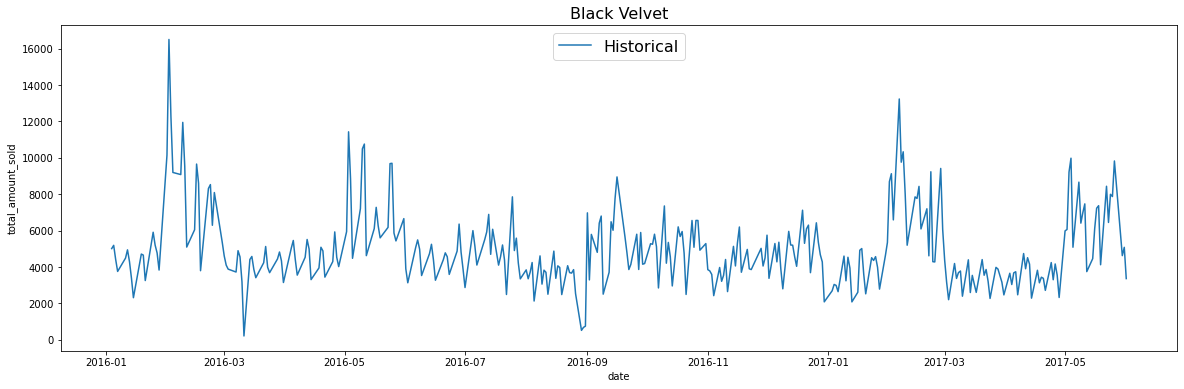

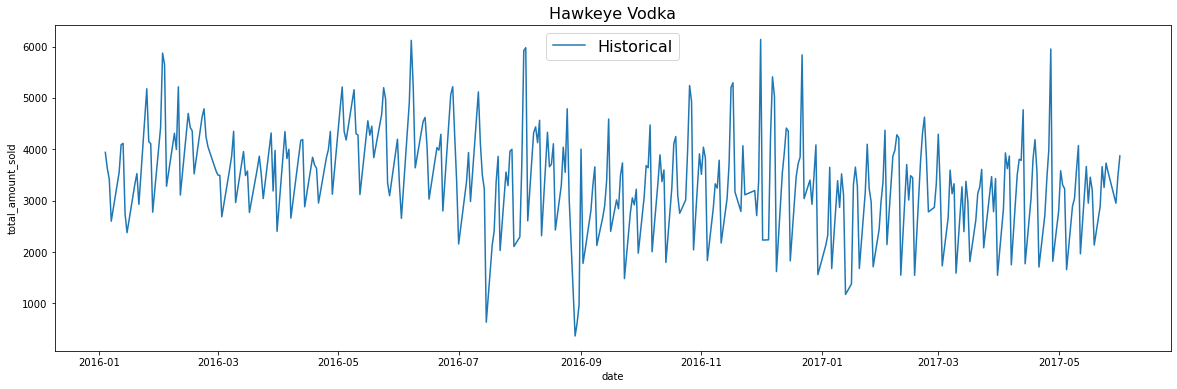

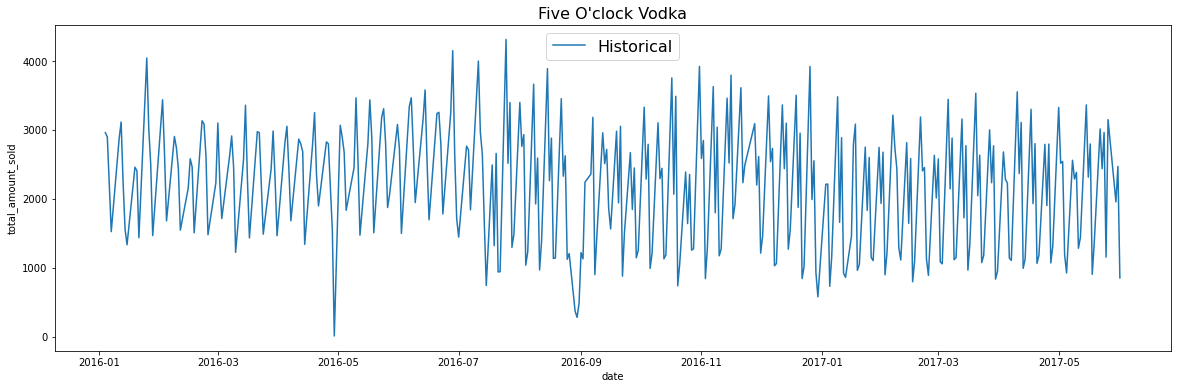

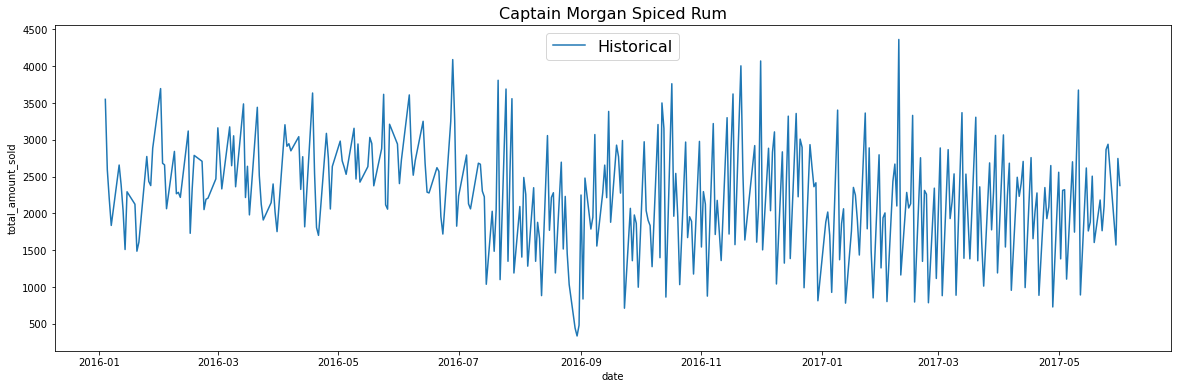

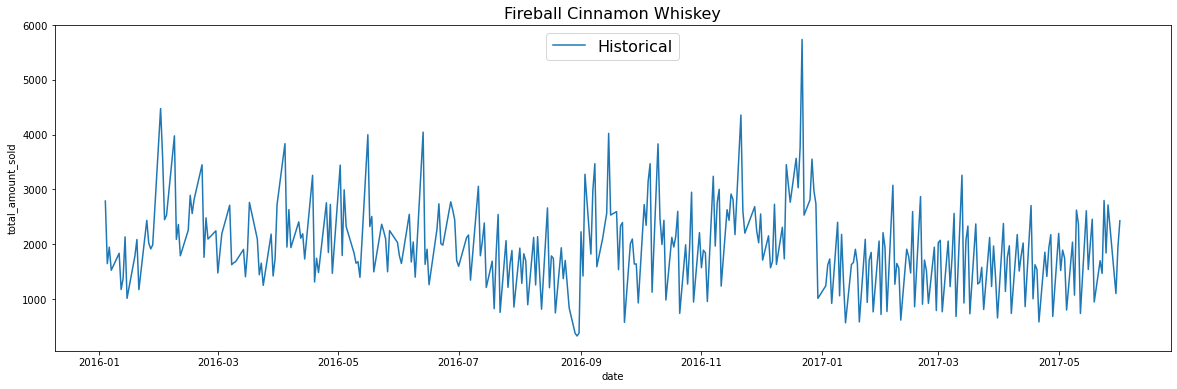

In [8]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    
    datah = dfhistorical[dfhistorical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = item)

#### Train the time series model

Since you are training the model on multiple products in a single model creation statement, you will need to specify the parameter `TIME_SERIES_ID_COL` as `item_name`. Note that if you were only forecasting a single item, then you would not need to specify `TIME_SERIES_ID_COL`. For more information, see the [BigQuery ML time series model creation documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#create_model_syntax).

Time series modeling in BigQuery ML can also account for holiday effects. By default, holiday effects modeling is disabled. But since this data is from the United States, and the data includes a minimum one year of daily data, you can also specify an optional `HOLIDAY_REGION`. With holiday effects enabled, spike and dip anomalies that appear during holidays will no longer be treated as anomalies. A full list of the holiday regions can be found in the [HOLIDAY_REGION documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series#holiday_region).



In [9]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    item_name,
    total_amount_sold
FROM
  bqmlforecast.training_data

""


### Evaluate the model

You can use the `ML.EVALUATE` function to see the evaluation metrics of all the created models. 

The following four columns (`non_seasonal_`{`p`,`d`,`q`} and `has_drift`) define an ARIMA model. The three metrics after that (`log_likelihood`, `AIC`, and `variance`) are relevant to the ARIMA model fitting process. The fitting process determines the best ARIMA model by using the auto.ARIMA algorithm, one for each time series.

In [10]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_model)

,item_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,Black Velvet,2,1,2,True,-4151.002,8314.005,601051.385,[WEEKLY]
1,Captain Morgan Spiced Rum,1,1,2,False,-3717.323,7442.645,111758.705,[WEEKLY]
2,Fireball Cinnamon Whiskey,2,0,3,False,-3719.841,7453.683,22372.614,[WEEKLY]
3,Five O'clock Vodka,3,0,2,False,-3572.887,7159.773,61557.312,[WEEKLY]
4,Hawkeye Vodka,2,1,2,True,-3802.454,7616.907,154697.480,[WEEKLY]


As you can see, there were five models trained, one for each of the products in _item_name_. Each model has its own p,d,q hyperparameters for ARIMA, and the detected seasonality for these five models was _WEEKLY_.

### Make predictions using the model

Make predictions using `ML.FORECAST` ([syntax documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-forecast)), which forecasts the next n values, as set in `horizon`. You can also change the `confidence_level`, the percentage that the forecasted values fall within the prediction interval.

In [11]:
%%bigquery dfforecast --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL bqmlforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

In [12]:
dfforecast.head()

,item_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,Black Velvet,2017-06-02 00:00:00+00:00,1783.563,776.011,0.900,508.522,3058.603,508.522,3058.603
1,Black Velvet,2017-06-03 00:00:00+00:00,2613.904,992.778,0.900,982.700,4245.109,982.700,4245.109
2,Black Velvet,2017-06-04 00:00:00+00:00,3213.561,1146.609,0.900,1329.602,5097.521,1329.602,5097.521
3,Black Velvet,2017-06-05 00:00:00+00:00,3989.719,1232.544,0.900,1964.562,6014.876,1964.562,6014.876
4,Black Velvet,2017-06-06 00:00:00+00:00,3229.698,1303.835,0.900,1087.405,5371.992,1087.405,5371.992


Since `horizon` is set to 30, the result is 30 x (number of items), with one row per forecasted value:

In [13]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 150


#### Inspect the ARIMA model coefficients

You can view the coefficients of each of the ARIMA models using `ML.ARIMA_COEFFICIENTS` ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients)).

For each of the models, ar_coefficients shows the model coefficients of the autoregressive (AR) part of the ARIMA model. Similarly, ma_coefficients shows the model coefficients of moving-average (MA) part. They are both arrays, whose lengths are equal to non_seasonal_p and non_seasonal_q, respectively. The intercept_or_drift is the constant term in the ARIMA model.

In [14]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)

,item_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,Black Velvet,"[-0.07711943185589054, 0.7972580295959335]","[-0.12683862533540985, -0.8731611421564899]",-3.701
1,Captain Morgan Spiced Rum,[0.7406577416929963],"[-1.249940074231941, 0.27581025860863473]",0.000
2,Fireball Cinnamon Whiskey,"[-0.03377222263638234, 0.7117121456055502]","[0.724193810409291, -0.08894112827578475, -0.0...",1622.083
3,Five O'clock Vodka,"[0.1393742708908336, -0.34533088349210017, 0.3...","[0.4630675491483075, 0.9855299019564044]",2122.557
4,Hawkeye Vodka,"[-0.18816379236514957, 0.7489033849903395]","[-0.07514040120901366, -0.924859360410754]",-2.042


#### Plot the forecasted predictions

Plot the forecasted predictions:

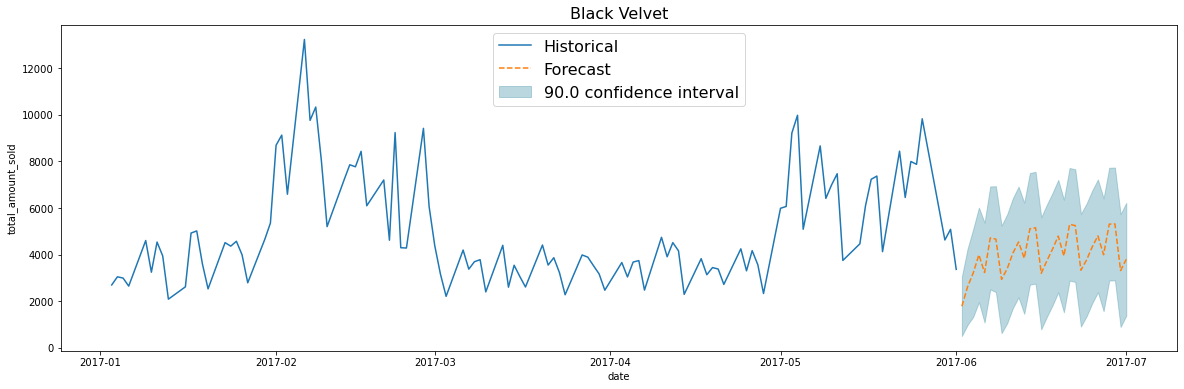

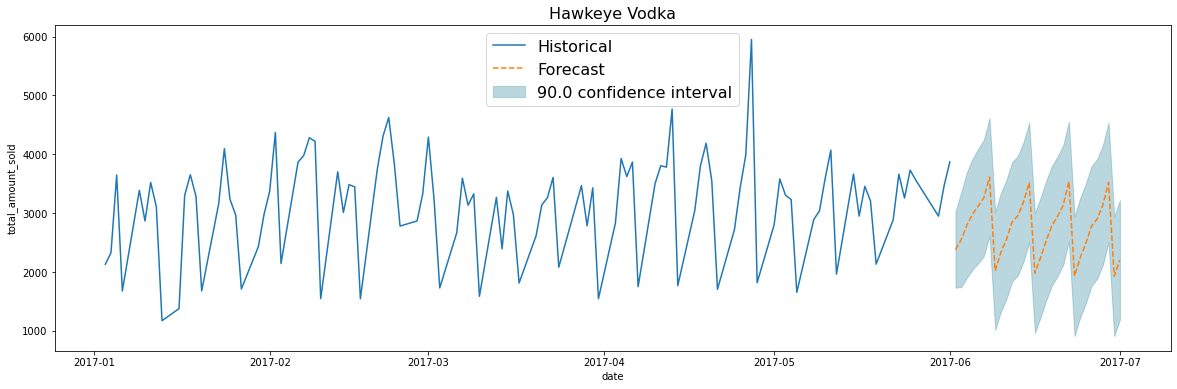

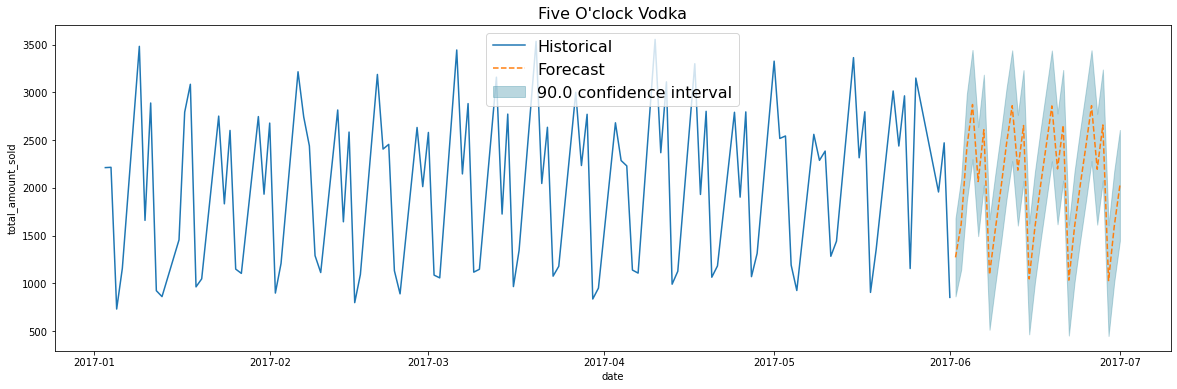

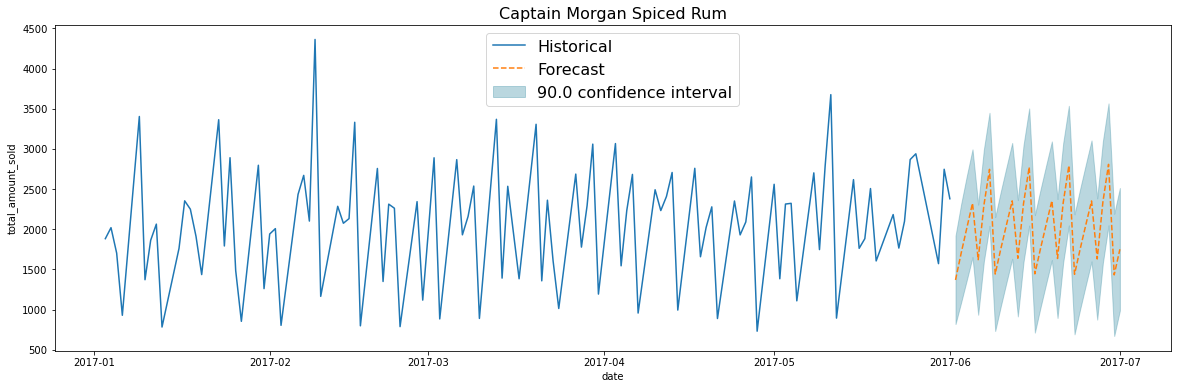

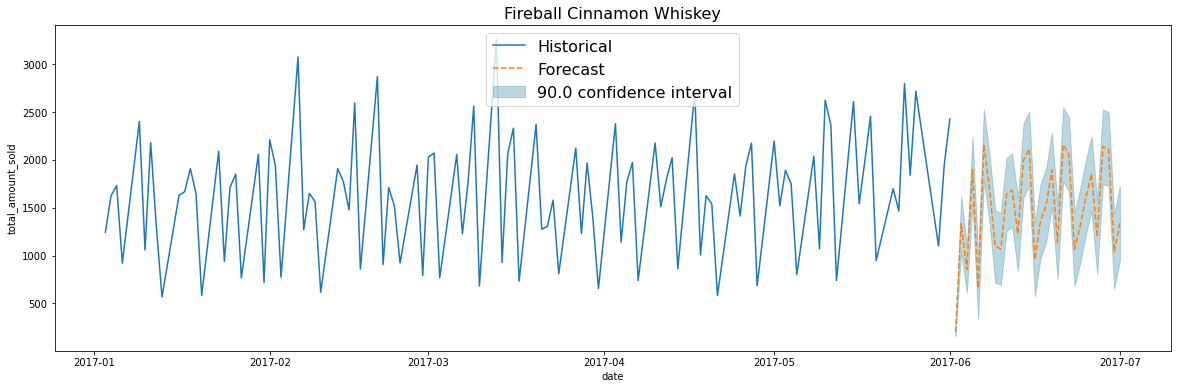

In [15]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item]
    dataf = dfforecast[dfforecast.item_name==item]
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = item,
                                 plotstartdate = "2017-01-01")

#### Plot the forecasted predictions against the actual data

To visualize the data in Python, first save the data to a Pandas dataframe.

In [16]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast

SELECT 
    date,
    item_description AS item_name,
    SUM(bottles_sold) AS total_amount_sold
FROM
    `bigquery-public-data.iowa_liquor_sales.sales` 
GROUP BY
    date, item_name
HAVING 
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    date;

In [17]:
dfactual.head()

,date,item_name,total_amount_sold
0,2017-06-02,Caribbean Cask Rye Whiskey,61
1,2017-06-02,Juarez Gold Dss,84
2,2017-06-02,Bacardi Gran Reserva Maestro,12
3,2017-06-02,Everclear Alcohol,71
4,2017-06-02,Templeton 4YR Rye,47


Plot the forecasted predictions against the actual values:

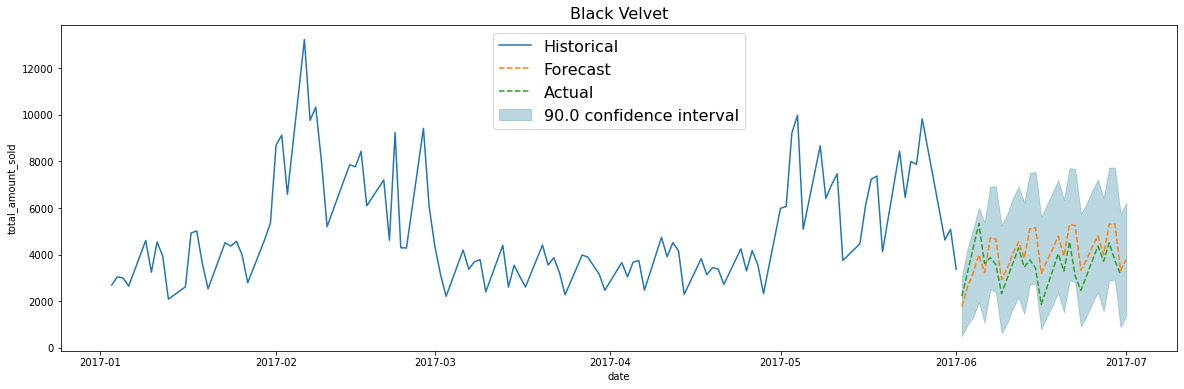

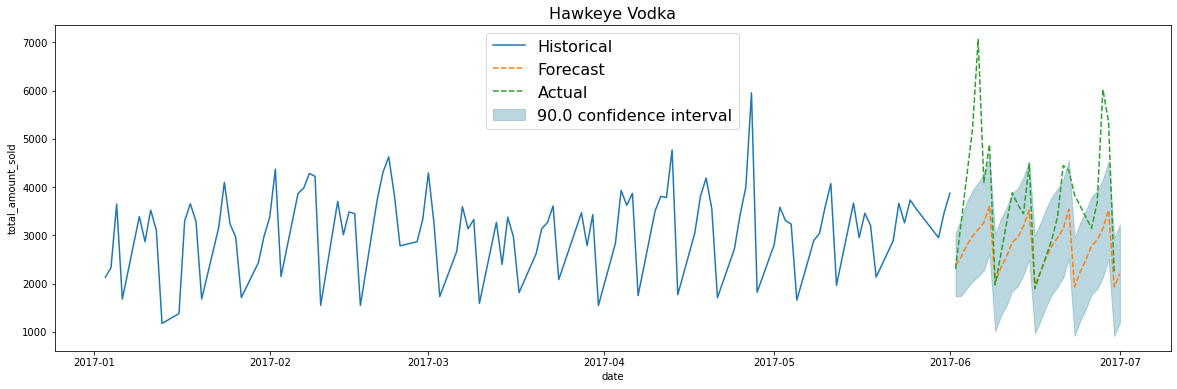

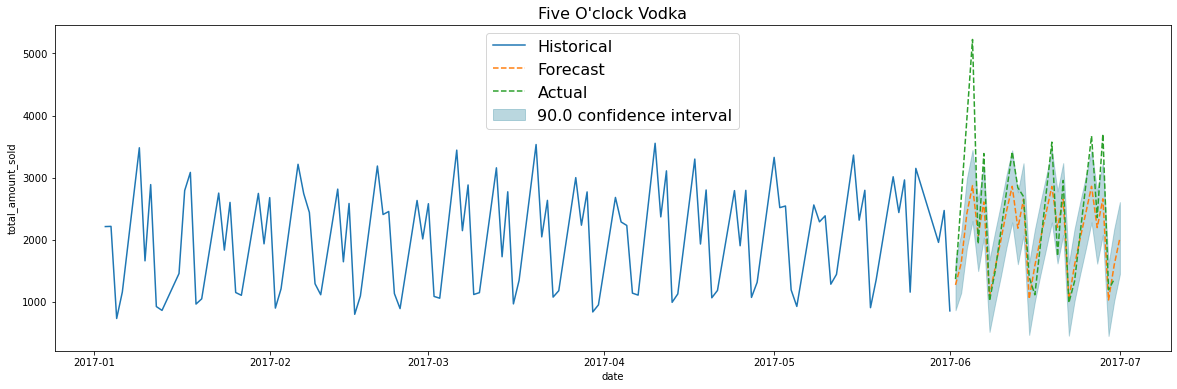

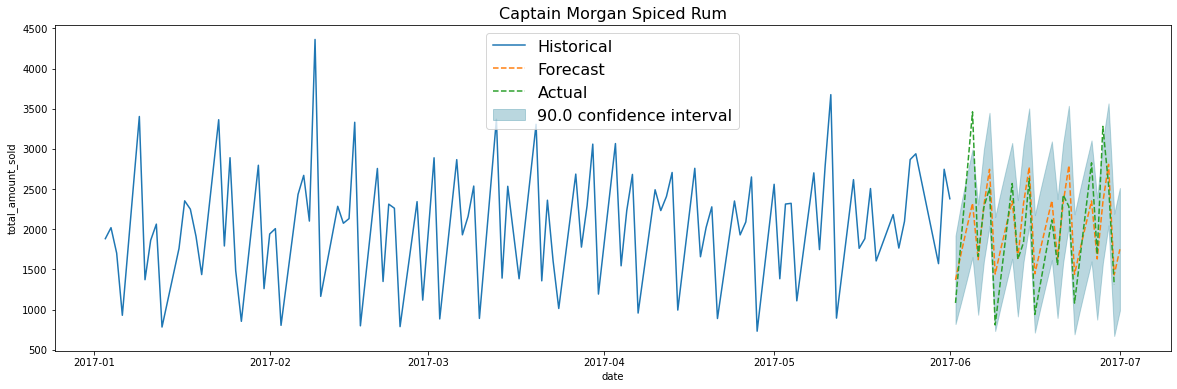

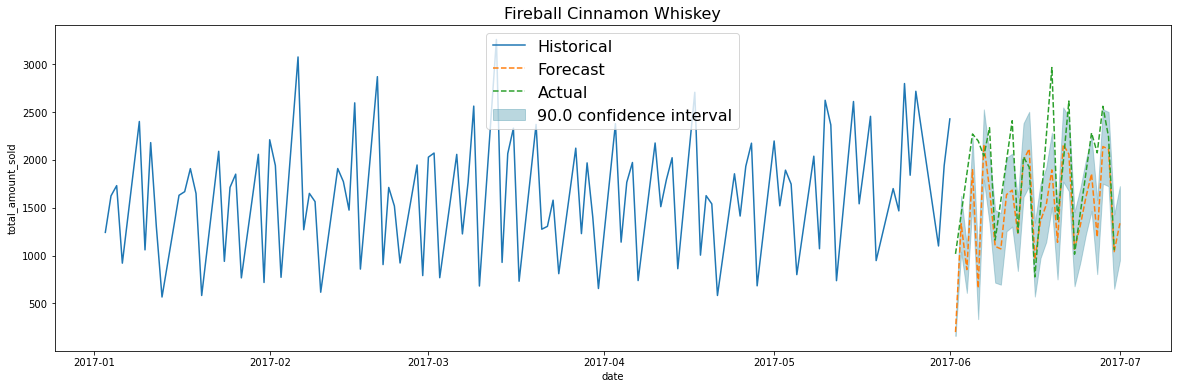

In [18]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].sort_values('date')
    dataf = dfforecast[dfforecast.item_name==item].sort_values(['forecast_timestamp'])
    dataa = dfactual[dfactual.item_name==item].sort_values('date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "date", 
                             data_col_name = "total_amount_sold", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = item,
                             plotstartdate = "2017-01-01")

## What to do with the forecasted results

### Create a dashboard with Data Studio

Follow the steps below to create an interactive, shareable dashboard of the forecasted data using Data Studio. 

(1) Create a view that concatenates the historical time series and the forecasted time series as shown in the following example query.

In [19]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

""


The SQL before the `UNION ALL` clause forms the history time series. The SQL after the `UNION ALL` clause uses `ML.FORECAST` to generate the forecasted time series as well as the prediction interval. This example uses different fields for `history_value` and `forecasted_value` to plot them in different colors.

(2) Using the [BigQuery UI](https://console.cloud.google.com/bigquery), navigate to your view (`bqmlforecast.outputdata_datastudio`) and click **Export** to **Explore with Data Studio**. A new tab opens in the browser.

<img src="images/bq_export_datastudio.png" align="left">

(3) In the **Chart** panel, find the **Time series chart** icon and click it, as shown in the following screenshot.

<img src="images/datastudio_charts.png" align="left">

(4) Under the **Chart** panel, in the **Data** panel, find the **Metric** section. Add the following metrics: `history_value`, `forecast_value`, `prediction_interval_lower_bound`, and `prediction_interval_upper_bound`. Then, remove the default metric **Record Count** as shown in the following screenshot.

<img src="images/datastudio_chartsettings.png" align="left">

(5) In the **Style** panel, scroll down to the **Missing Data** option and use **Linear Interpolation** (or **Line Breaks**) instead of **Line to Zero**.

<img src="images/datastudio_missingdata.png" align="left">

(6) In the **Filter** panel, add `item_name`, and select a single liquor product (e.g., **Five O'clock Vodka**) to inspect the time series data for just that product.

<img src="images/datastudio_filter_item.png" align="left">

(7) After you complete these steps, the following plot appears in the left panel. The input history time series is in blue, while the forecasted series is in green. The prediction interval is the region between the lower bound series and the upper bound series.

<img src="images/datastudio_fiveoclockvodka.png" align="left">